In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Set up

In [73]:
df = pd.read_csv('puf2011.csv')

df = df[(df['RECID'] != 999996) &
        (df['RECID'] != 999997) &
        (df['RECID'] != 999998) &
        (df['RECID'] != 999999)
       ]
           
df = df.fillna(0)

## Check `E00650` and `E00600`

As was hypothesized

In [74]:
np.corrcoef(df.E00650, df.E00600)[0][1]

0.9395761242591618

In [75]:
df.shape[0]

163786

In [76]:
df_E00650_E00600 = df[(df.E00650 + df.E00600) > 0.]

In [77]:
df_E00650_E00600.shape[0]

67813

In [78]:
np.corrcoef(df_E00650_E00600.E00650, df_E00650_E00600.E00600)[0][1]

0.939040576302187

E00650 is removed from following analysis

## Is `E01100` colinear with others?

In [79]:
# Predictors except E00650, E01100 
predictors =  ['DSI', 'EIC', 'MARS', 'XTOT', 'E00200', 'E00300', 'E00400','E00600', 
                          'E00800', 'E00900',          'E01400', 'E01500', 'E01700',
               'E02100', 'E02300', 'E02400', 'E03150', 'E03210', 'E03240', 'E03270',
               'E03300', 'E17500', 'E18400', 'E18500', 'E19200', 'E19800', 'E20100',
               'E20400', 'E32800', 'F2441', 'N24']


predictors_plus_E01100 = predictors + ['E01100']

df = df[predictors_plus_E01100]

In [80]:
for i in predictors:
    corr = np.corrcoef(df.E01100, df[i])[0][1]
    print(i + ': ' + corr.astype(str))

DSI: -0.002450304407952469
EIC: -0.005770364072514708
MARS: -0.0005345798427549097
XTOT: 0.003859083819616031
E00200: 0.007005752776752023
E00300: -0.0003081428323845073
E00400: -0.0010374916953898746
E00600: 0.008484113561486501
E00800: -0.0002781844272934732
E00900: 0.005034885370630819
E01400: 0.0001884732076324321
E01500: 0.0015660212505961425
E01700: 0.0021503875160369416
E02100: 0.00014753560516280164
E02300: -0.0016594135443888484
E02400: -0.001440884039744523
E03150: 0.0008620084203943303
E03210: -0.0031823725541633035
E03240: 0.019969662889072242
E03270: 0.00860532275779318
E03300: 0.0014293979288300587
E17500: -0.0013407913784136928
E18400: 0.004602040473329941
E18500: 0.004892294056842053
E19200: -0.001167531869777565
E19800: 0.000551298700281853
E20100: -0.00037768355066800183
E20400: 8.729182348313901e-05
E32800: -0.001601310212416729
F2441: -0.0014562877461278545
N24: 0.0009255279089733505


No not really.

## Check general collinearity

Check collinearity per https://stackoverflow.com/a/25833792/1840471. Any value close to 0 in the eigenvector points to collinearity.

In [81]:
def min_eig(df):
    corr = np.corrcoef(df, rowvar=0)
    w, v = np.linalg.eig(corr) 
    return w.min()

In [82]:
min_eig(df[predictors_plus_E01100])

0.15278109560387398

Now after removing `E01100`

In [83]:
min_eig(df[predictors])

0.1527811046902145

Remove each feature from `predictors` and recheck collinearity.

In [84]:
for i in predictors_plus_E01100:
    print(i + ': ' + 
          min_eig(df[predictors_plus_E01100].drop(i, axis=1)).astype(str))

DSI: 0.15320833091562402
EIC: 0.153592027315085
MARS: 0.15286895824299554
XTOT: 0.153506038604724
E00200: 0.15280520705294712
E00300: 0.15278275585177792
E00400: 0.1527814464329546
E00600: 0.15278145772391308
E00800: 0.15278188544958599
E00900: 0.1527811322684748
E01400: 0.15278349308877553
E01500: 0.1527919279589253
E01700: 0.1527813791518063
E02100: 0.15278155258264126
E02300: 0.15278479319798172
E02400: 0.15283505651650942
E03150: 0.15278471933203047
E03210: 0.1528049153436615
E03240: 0.1527812206792059
E03270: 0.15280752805448647
E03300: 0.15282510149299544
E17500: 0.15278190728315486
E18400: 0.15278263606480375
E18500: 0.15280796889245815
E19200: 0.15278592480437017
E19800: 0.1527811777152562
E20100: 0.15278112980902023
E20400: 0.15278960657747268
E32800: 0.16848649076965214
F2441: 0.1692281661687451
N24: 0.1542546921607233
E01100: 0.1527811046902145


Neither E01100 or other PUF variables appear to be greatly collinear with the other PUF variables.

## `E19800` vs `E20100`

E19800 and E20100 are not highly correlated in PUF, though they might be combined to form one predictor given that they are one variable in CPS that was split into two by a constant ratio.

In [85]:
np.corrcoef(df.E19800, df.E20100)[0][1]

0.2212186664978193

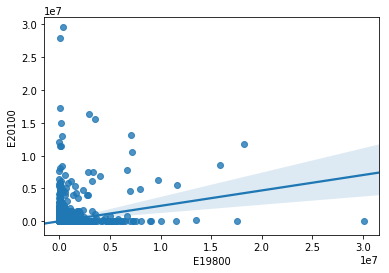

In [86]:
sns.regplot(df.E19800, df.E20100)
plt.show()

## Check general correlations

In [99]:
# corr_not_1 = absolute-valued correlation matrix where all 1's replaced with NaN's. 
# Note that E01100 is included in this matrix, E00650 is excluded. 

corr = df[predictors_plus_E01100].corr().abs()
corr_not_1 = corr[corr != 1]

corr_max = corr_not_1.idxmax(axis = 1)

print('Predictors and their highest correlates:\n')
print(corr_max)

Predictors and their highest correlates:

DSI         XTOT
EIC         MARS
MARS        XTOT
XTOT         N24
E00200    E18400
E00300    E20400
E00400    E18500
E00600    E20400
E00800      XTOT
E00900    E03300
E01400    E02400
E01500    E01700
E01700    E01500
E02100    E00600
E02300    E18500
E02400       N24
E03150    E03270
E03210    E02400
E03240    E18400
E03270    E03300
E03300    E03270
E17500    E02400
E18400    E00200
E18500    E18400
E19200    E20400
E19800    E00300
E20100    E19800
E20400    E00300
E32800     F2441
F2441     E32800
N24         XTOT
E01100    E03240
dtype: object


In [100]:
# corr_vals = the correlation values associated with the correlation pairs in corrs_max, pulled from corr_not_1

corr_vals = []
for i in corrs_max.iteritems():
    corr_vals.append(corr_not_1.loc[i[0], i[1]])

# df matching correlation pairs with correlation values
    
corrs_max_df = pd.DataFrame({'Corr': corrs_max, 'Value': corr_vals})

print('\nMaximum correlation pairs and their correlations values:')

corrs_max_df.sort_values('Value', ascending = False)


Maximum correlation pairs and their correlations values:


,Corr,Value
F2441,E32800,0.843953
E32800,F2441,0.843953
N24,XTOT,0.771928
XTOT,N24,0.771928
MARS,XTOT,0.424276
E00200,E18400,0.400148
E18400,E00200,0.400148
E00300,E20400,0.400075
E20400,E00300,0.400075
EIC,MARS,0.391848
